# 1. Import Libraries

In [150]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from scipy.signal import savgol_filter


# 2. Load and Preprocess Raw Data

## Folder Structure

The raw dataset is collected from ground black pepper measured via NIR machine with structure as follow:
```
📁 NIR data (ground)/
├── Date folders (e.g. 2022-06-23)/
│ └── Code folders (e.g. 00141_27)/
│ └── CSV files of NIR spectra (e.g. Hadamard1_101209_20220623_170624.csv,...)
📄 Info.xlsx → province mapping
```

Each subfolder (e.g., 00141_27) contains multiple .csv files, each of them representing the NIR spectra of black pepper samples.
The prefix of subfolder name (e.g 00141 part) is a sample code, which is used to map to its Province label from the external file Info.xlsx.

Each CSV file contains:
Meta data
Wavelengths (900–1700 nm)
Absorbance values per sample

=> Only the columns `Wavelength` and `Absorbance` need to be extracted for modeling.



## Preprocessing Workflow

| Step | Description |
|------|-------------|
| ✅ 1 | Read `Info.xlsx` and create a `Code ↔ Province` mapping |
| ✅ 2 | Walk through all folders and locate `.csv` files |
| ✅ 3 | Detect `"Wavelength"` section and parse absorbance data |
| ✅ 4 | Reshape each file into one row with absorbance values |
| ✅ 5 | Add metadata: `Code`, `Province`, `SourceFile` |

###Final Dataset Format

After parsing, the final dataframe (`final_df`) has the shape:

| 900.8 | 901.6 | ... | 1700.0 | Code | Province |
|--------|--------|------|--------|------|----------|
| 0.212  | 0.210  | ...  | 0.321  | 00141 | GiaLai   |
| ...    | ...    | ...  | ...    | ...   | ...      |

- ~2,802 samples  
- ~228 wavelengths (features)  
- 5 provinces (classes)


In [ ]:
mapping_df = pd.read_excel("Info.xlsx", skiprows=1).iloc[:, [1, -1]].dropna()
mapping_df.columns = ['Code', 'Province']
mapping_df['Code'] = mapping_df['Code'].astype(str).str.slice(5, 10)

def read_nir_file(file_path, code, province, filename):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    start_idx = next((i for i, line in enumerate(lines) if line.strip().lower().startswith("wavelength")), None)
    if start_idx is None:
        raise ValueError(f"No 'Wavelength' line in {file_path}")
    
    df = pd.read_csv(file_path, skiprows=start_idx).iloc[:, :2]
    df.columns = ['Wavelength', 'Absorbance']
    df_pivot = df.set_index('Wavelength').T
    df_pivot['Code'] = code
    df_pivot['Province'] = province
    df_pivot['SourceFile'] = filename
    return df_pivot

root_dir = "NIR data (ground)"
all_data = []

for date_folder in os.listdir(root_dir):
    date_path = os.path.join(root_dir, date_folder)
    if not os.path.isdir(date_path):
        continue

    for code_folder in os.listdir(os.path.join(root_dir, date_folder)):
        path = os.path.join(root_dir, date_folder, code_folder)
        if not os.path.isdir(path):
            continue
        code = code_folder.split('_')[0]
        province_row = mapping_df[mapping_df['Code'] == code]
        if province_row.empty:
            continue
        province = province_row['Province'].values[0]
        for filename in os.listdir(path):
            if filename.endswith(".csv"):
                try:
                    df = read_nir_file(os.path.join(path, filename), code, province, filename)
                    all_data.append(df)
                except Exception as e:
                    print(f"Error reading {filename}: {e}")

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv("NIR_full_data.csv", index=False)


In [185]:
final_df.head()

Wavelength,901.800507,905.727250,909.649623,913.567626,917.481259,921.390522,925.295415,929.195937,933.092090,936.983873,...,1673.981410,1676.942091,1679.898431,1682.850430,1685.798089,1688.741406,1691.680383,1694.615018,1697.545313,1701.445620
0,0.471489,0.413035,0.394602,0.370502,0.398665,0.404830,0.413010,0.399559,0.380721,0.395452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.388932,0.385080,0.375353,0.373175,0.370857,0.366160,0.363943,0.362578,0.358308,0.353715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.386634,0.404312,0.383114,0.399767,0.382268,0.387949,0.375238,0.378923,0.371087,0.365095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.412286,0.407985,0.396407,0.393622,0.389905,0.386414,0.381633,0.378892,0.374584,0.369130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.425005,0.429885,0.411809,0.405484,0.391825,0.390592,0.391960,0.386618,0.390359,0.376276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data was collected from two different NIR devices, each covering different wavelength ranges, so we dropped rows with NaN. To ensure consistent input for modeling, only samples with full spectral data were retained in the next step.

## Clean and Prepare Dataset

In [187]:
df_subset = final_df.loc[:, :'Province'].copy()
df_subset.replace(['', ' '], pd.NA, inplace=True)
df_cleaned = df_subset.dropna()
df_cleaned.to_csv('NIRdata_processed.csv', index=False)

In [188]:
df_cleaned.head()

Wavelength,901.800507,905.72725,909.649623,913.567626,917.481259,921.390522,925.295415,929.195937,933.09209,936.983873,...,1680.094757,1683.030945,1685.962764,1688.890213,1691.813292,1694.732,1697.646339,1700.556307,Code,Province
0,0.471489,0.413035,0.394602,0.370502,0.398665,0.404830,0.413010,0.399559,0.380721,0.395452,...,-0.362535,-0.353933,-0.363701,-0.339253,-0.307615,-0.268389,-0.283379,-0.298210,00373,VungTau
1,0.388932,0.385080,0.375353,0.373175,0.370857,0.366160,0.363943,0.362578,0.358308,0.353715,...,-0.452828,-0.453915,-0.443830,-0.437194,-0.423038,-0.412458,-0.411711,-0.387747,00373,VungTau
2,0.386634,0.404312,0.383114,0.399767,0.382268,0.387949,0.375238,0.378923,0.371087,0.365095,...,-0.395190,-0.395134,-0.379232,-0.374131,-0.354245,-0.356505,-0.339378,-0.331988,00373,VungTau
3,0.412286,0.407985,0.396407,0.393622,0.389905,0.386414,0.381633,0.378892,0.374584,0.369130,...,-0.413352,-0.415235,-0.406079,-0.397991,-0.383361,-0.373073,-0.373472,-0.348180,00373,VungTau
4,0.425005,0.429885,0.411809,0.405484,0.391825,0.390592,0.391960,0.386618,0.390359,0.376276,...,-0.352980,-0.363707,-0.345765,-0.342962,-0.323858,-0.323904,-0.324650,-0.282905,00373,VungTau


In [189]:
df_cleaned.describe()

Wavelength,901.800507,905.727250,909.649623,913.567626,917.481259,921.390522,925.295415,929.195937,933.092090,936.983873,...,1674.209268,1677.154198,1680.094757,1683.030945,1685.962764,1688.890213,1691.813292,1694.732000,1697.646339,1700.556307
count,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,...,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000,2802.000000
mean,0.379711,0.375881,0.367336,0.364927,0.362140,0.358273,0.354878,0.353896,0.350480,0.345744,...,-0.335045,-0.357463,-0.369658,-0.371009,-0.359675,-0.352202,-0.338133,-0.328993,-0.325443,-0.302003
std,0.060670,0.060511,0.059940,0.059854,0.059546,0.059079,0.058489,0.057991,0.057832,0.057447,...,0.046991,0.047276,0.048130,0.049177,0.050379,0.051507,0.052389,0.053444,0.053493,0.053851
min,0.097084,0.145974,0.183339,0.181186,0.186972,0.194226,0.210622,0.209028,0.209148,0.203284,...,-0.447140,-0.469087,-0.482302,-0.486510,-0.503919,-0.526766,-0.547366,-0.462954,-0.466709,-0.434415
25%,0.334269,0.330213,0.322191,0.319549,0.316977,0.313461,0.310281,0.309745,0.306945,0.302350,...,-0.368370,-0.390389,-0.403078,-0.404969,-0.394726,-0.388651,-0.375059,-0.366505,-0.362679,-0.339721
50%,0.377316,0.373603,0.365047,0.362100,0.359032,0.355492,0.352733,0.351127,0.347158,0.343292,...,-0.338247,-0.361154,-0.373362,-0.374346,-0.363224,-0.354961,-0.341294,-0.331337,-0.327715,-0.304026
75%,0.425606,0.421443,0.413300,0.410089,0.407502,0.403070,0.399068,0.397947,0.394087,0.388964,...,-0.302992,-0.324970,-0.336467,-0.337560,-0.325125,-0.316778,-0.302829,-0.292920,-0.289513,-0.266309
max,0.652059,0.647208,0.639531,0.633245,0.629499,0.630156,0.625867,0.624986,0.624573,0.618354,...,-0.061870,-0.083489,-0.094602,-0.096208,-0.083893,-0.075917,-0.063700,-0.048783,-0.045153,-0.018353


# 3.Exploratory Data Analysis (EDA)

## Plot sample count per province

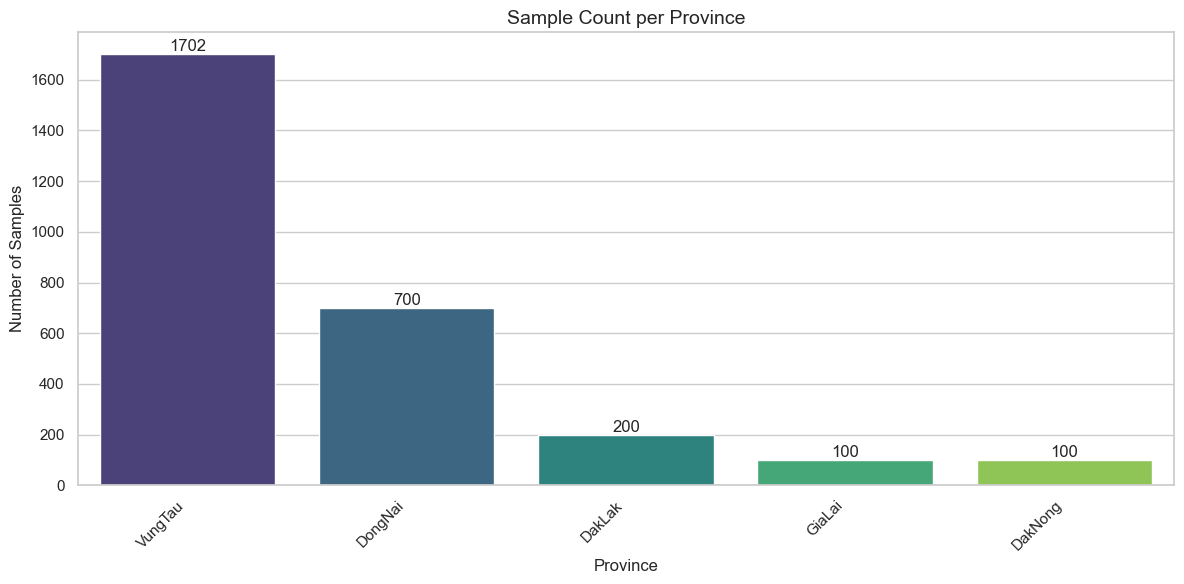

In [ ]:
sns.set_theme(style="whitegrid")

province_counts = df_cleaned["Province"].value_counts().reset_index()
province_counts.columns = ["Province", "Count"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=province_counts,
    x="Province",
    y="Count",
    hue="Province",        
    dodge=False,
    palette="viridis",
    legend=False           
)


for i, row in province_counts.iterrows():
    ax.text(i, row["Count"] + 0.5, str(row["Count"]), ha="center", va="bottom")


plt.title("Sample Count per Province", fontsize=14)
plt.xlabel("Province")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Plot Mean ± Std of Spectra

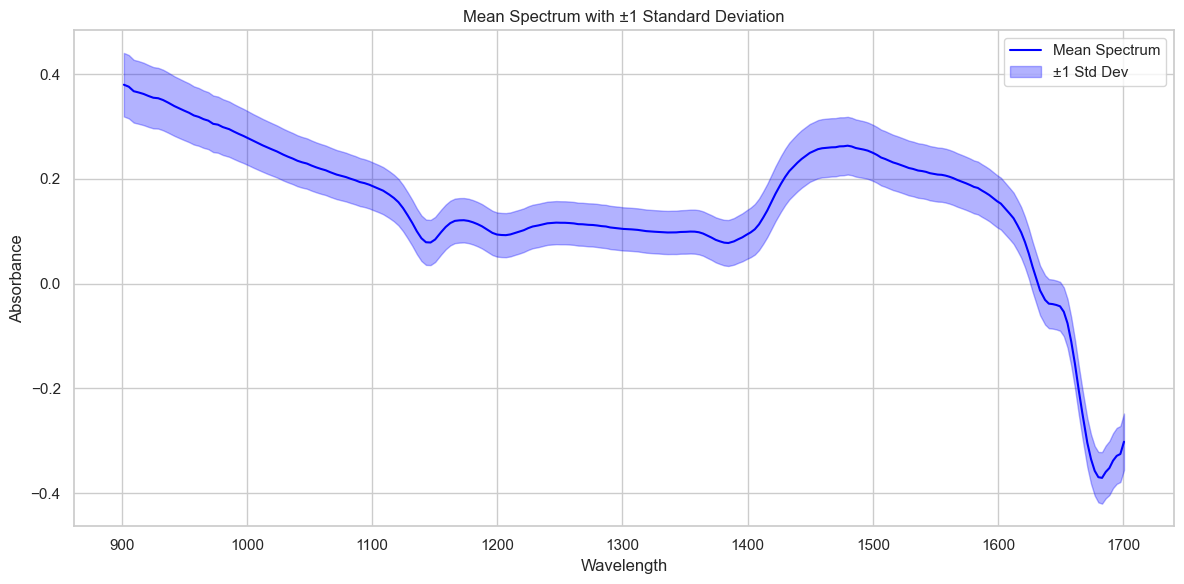

In [ ]:
X = df_cleaned.drop(columns=['Code', 'Province'])
y = df_cleaned['Province']

mean_spectrum = X.mean()
std_spectrum = X.std()

plt.figure(figsize=(12, 6))
plt.plot(mean_spectrum.index.astype(float), mean_spectrum, label='Mean Spectrum', color='blue')
plt.fill_between(mean_spectrum.index.astype(float),
                 mean_spectrum - std_spectrum,
                 mean_spectrum + std_spectrum,
                 color='blue', alpha=0.3, label='±1 Std Dev')
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.title('Mean Spectrum with ±1 Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot shows the average NIR absorbance spectra across provinces, with shaded regions representing one standard deviation. This visualization reveals both spectral patterns and inter-provincial variability.

Key Observations:

900–950 nm
→ Second overtone of C–H stretching, typical in hydrocarbons and lipids.

1150–1170 nm
→ C–H combination bands and first overtone of O–H stretching, related to alcohols or moisture content.

1450–1500 nm
→ Strong O–H stretching overtone, indicating water content differences.

1600–1700 nm
→ N–H and C–H combination bands, potentially linked to proteins and nitrogenous compounds.

1000–1100 nm, 1300–1400 nm
→ Lower variance regions, less helpful for classification.

Interpretation:

These patterns suggest chemical composition differences (moisture, lipids, proteins) among provinces. Specific wavelength bands may serve as features for dimensionality reduction (e.g., PCA) or supervised classification models. Combining domain knowledge with statistical variance supports more interpretable and accurate modeling.

## PCA 2D Visualization

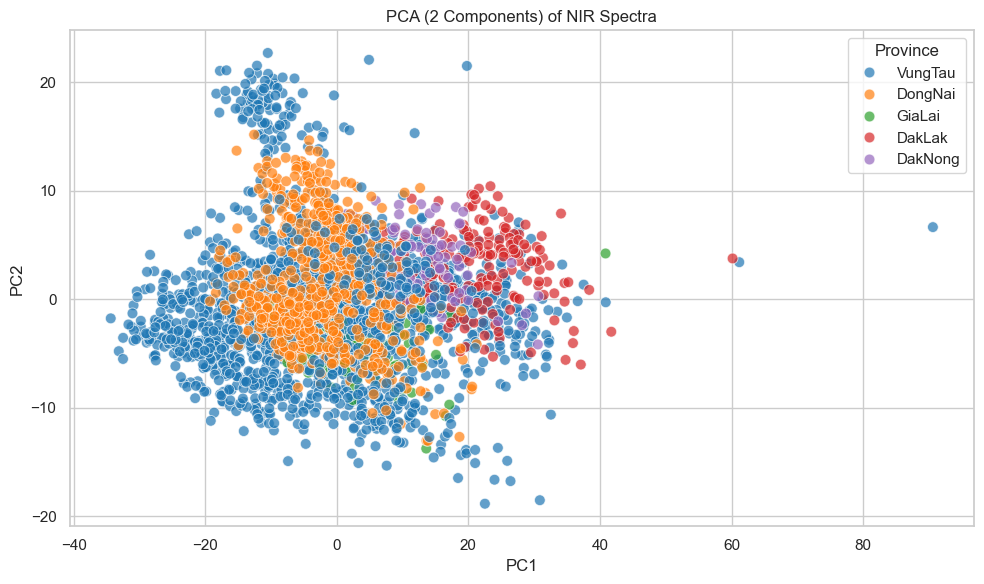

In [ ]:
X_scaled = (X - X.mean()) / X.std()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Province'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Province', palette='tab10', s=60, alpha=0.7)
plt.title('PCA (2 Components) of NIR Spectra')
plt.grid(True)
plt.tight_layout()
plt.show()

The PCA plot using the first two principal components reveals clustering patterns among the pepper samples based on their geographic origin. Provinces like VungTau and DongNai show relatively distinct groupings, suggesting that their spectral profiles are different. Meanwhile, samples from DakLak and DakNong overlap, indicating more similar spectral characteristics. This visualization confirms that NIR spectra contain relevant information for classification by origin, but also highlights the need for machine learning models to achieve accurate separation.

# 4. Modeling approach

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Define Preprocessing Functions

In [ ]:
def snv(X):
    X = X.values if isinstance(X, pd.DataFrame) else X.reshape(1, -1)
    mean = np.mean(X, axis=1).reshape(-1, 1)
    std = np.std(X, axis=1).reshape(-1, 1) + 1e-8
    return (X - mean) / std
def deriv1(X): return savgol_filter(X, 11, 2, deriv=1, axis=1)
def deriv2(X): return savgol_filter(X, 11, 2, deriv=2, axis=1)


X_proc = snv(X_train)        
X_proc = deriv1(X_proc)      
X_proc = StandardScaler().fit_transform(X_proc) 


## Setup Pipelines and Models

In [197]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'clf__C': [0.1, 1, 10],
        'clf__multi_class': ['ovr', 'multinomial']
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    'Random Forest': {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5]
    }
}

preprocessing_combinations = {
    'SNV + Deriv1': [
        ('snv', FunctionTransformer(snv)),
        ('deriv1', FunctionTransformer(deriv1)),
        ('scaler', StandardScaler())
    ],
    'SNV + Deriv2': [
        ('snv', FunctionTransformer(snv)),
        ('deriv2', FunctionTransformer(deriv2)),
        ('scaler', StandardScaler())
    ]
}


## Model Training & Evaluation

In [198]:
results = []
detailed_results = {}

for prep_name, prep_steps in preprocessing_combinations.items():
    for model_name, model in models.items():
        pipeline = Pipeline(prep_steps + [('clf', model)])
        grid = GridSearchCV(pipeline, param_grids[model_name], cv=cv, scoring='accuracy')
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred, output_dict=True)

        results.append((prep_name, model_name, grid.best_score_, acc, f1))

        # Save for later
        detailed_results[(prep_name, model_name)] = {
            'grid': grid,
            'report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred, labels=grid.classes_),
            'classes': grid.classes_,
            'y_pred': y_pred,
            'y_true': y_test
        }
results_df = pd.DataFrame(results, columns=['Preprocessing', 'Model', 'CV Accuracy', 'Test Accuracy', 'F1 Weighted'])
print(results_df)



  Preprocessing                Model  CV Accuracy  Test Accuracy  F1 Weighted
0  SNV + Deriv1  Logistic Regression     0.914335       0.909091     0.908430
1  SNV + Deriv1                  SVM     0.948238       0.946524     0.945109
2  SNV + Deriv1        Random Forest     0.901386       0.900178     0.895224
3  SNV + Deriv2  Logistic Regression     0.906744       0.898396     0.897777
4  SNV + Deriv2                  SVM     0.942879       0.921569     0.920221
5  SNV + Deriv2        Random Forest     0.900052       0.891266     0.884489


## Plot Result Summary

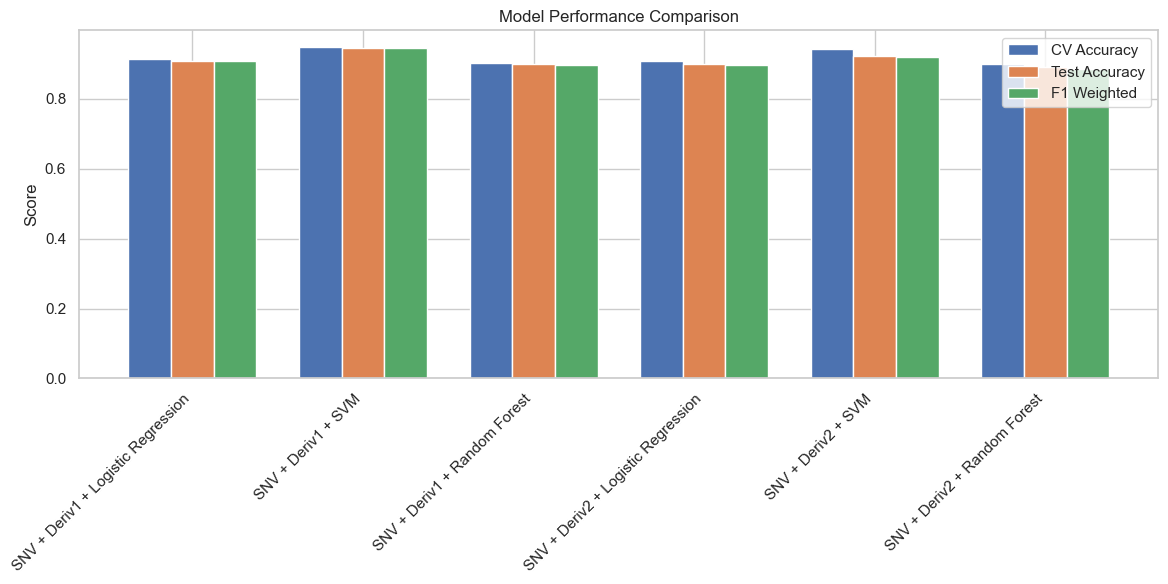

In [199]:

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
bar_width = 0.25

plt.bar(x - bar_width, results_df['CV Accuracy'], width=bar_width, label='CV Accuracy')
plt.bar(x, results_df['Test Accuracy'], width=bar_width, label='Test Accuracy')
plt.bar(x + bar_width, results_df['F1 Weighted'], width=bar_width, label='F1 Weighted')

labels = results_df['Preprocessing'] + " + " + results_df['Model']
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix of the best model


🏆 Best Model: SVM with SNV + Deriv1
Preprocessing    SNV + Deriv1
Model                     SVM
CV Accuracy          0.948238
Test Accuracy        0.946524
F1 Weighted          0.945109
Name: 1, dtype: object


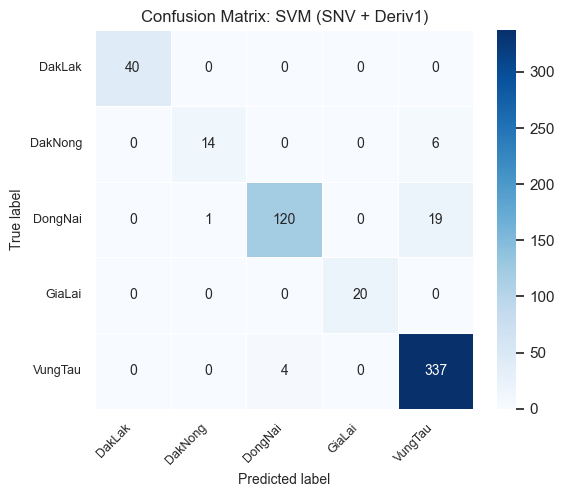

In [200]:

best_row = results_df.sort_values(by='Test Accuracy', ascending=False).iloc[0]
best_prep = best_row['Preprocessing']
best_model = best_row['Model']
print(f"\n🏆 Best Model: {best_model} with {best_prep}")
print(best_row)

cm = best_data['confusion_matrix']
classes = best_data['classes']
test_acc = accuracy_score(best_data['y_true'], best_data['y_pred'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})

plt.title(f"Confusion Matrix: {best_model} ({best_prep})", fontsize=12)
plt.xlabel("Predicted label", fontsize=10)
plt.ylabel("True label", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()